# Analysis of multivariate random variables

NOTE. For this lab you need subsample with 5-10 random variables, at least half of them should be described with continuous random variable type. Target variable should be continuous.

Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

Step 2. You need to make an estimation of multivariate mathematical expectation and variance.

Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

Step 6. Build regression model and make an analysis of multicollinearity and regularization (if needed).

Step 7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

Table of contents:

1. Plotting a non-parametric estimation of PDF in form of a histogram and kernel density function for MRV (or probability law in case of discrete MRV).

2. Estimation of multivariate mathematical expectation and variance.

3. Non-parametric estimation of conditional distributions, mathematical expectations and variances.

4. Estimation of pair correlation coefficients, confidence intervals for them and significance levels.

5. Task formulation for regression, multivariate correlation.

6. Regression model, multicollinearity and regularization (if needed).

7. Quality analysis

## 

## Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).


In [52]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [53]:
file = r'spotify_dataset.csv'
data = pd.read_csv(file)
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [54]:
variables = 'Danceability	Energy	Loudness	Valence Speechiness Acousticness Popularity Chord'
variables = variables.split()

N = len(data)
subdata = data[variables]
subdata = subdata[:N]
subdata = subdata.drop(subdata[subdata['Chord'] == " "].index)
cat_chord = subdata["Chord"].astype('category')
subdata["Chord"] = cat_chord.cat.codes
subdata

,Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Popularity,Chord
0,0.714,0.8,-4.808,0.589,0.0504,0.127,100,2
1,0.591,0.764,-5.484,0.478,0.0483,0.0383,99,4
2,0.563,0.664,-5.044,0.688,0.154,0.335,99,0
3,0.808,0.897,-3.712,0.591,0.0348,0.0469,98,2
4,0.736,0.704,-7.409,0.894,0.0615,0.0203,96,6
...,...,...,...,...,...,...,...,...
1551,0.762,0.7,-6.021,0.608,0.0694,0.00261,79,0
1552,0.528,0.87,-3.123,0.714,0.0851,0.24,66,2
1553,0.765,0.523,-4.333,0.394,0.03,0.184,81,5
1554,0.832,0.55,-7.026,0.881,0.0587,0.249,60,8


In [55]:
for col in subdata.columns:
    subdata[col] = pd.to_numeric(subdata[col], errors='coerce')
    subdata[col].fillna(subdata[col].mean(), inplace=True, downcast='infer')

subdata.dtypes

Danceability    float64
Energy          float64
Loudness        float64
Valence         float64
Speechiness     float64
Acousticness    float64
Popularity        int64
Chord              int8
dtype: object

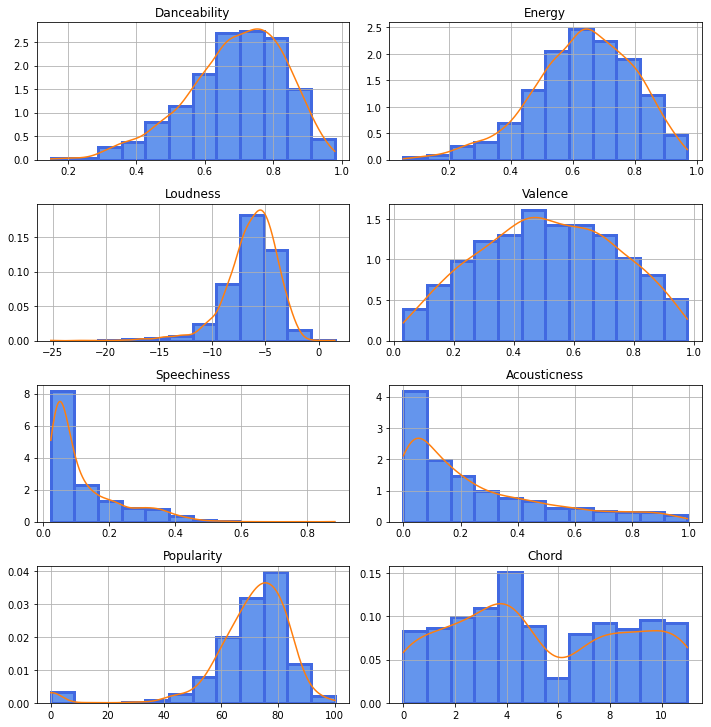

In [56]:
def plot_pdf_estimated(data,cols=2, kde=True,hist=True):
    plt.figure(figsize=(10,15))
    for i,col in enumerate(data.columns):
        m = 1 + 3.32*np.log10(len(data))
        m = int(np.round(m))
        N_cols = len(data.columns)
        plt.subplot(N_cols-cols,cols,i+1)
        
        if hist:
            data[col].hist(density=True,stacked=True,bins=m, facecolor='cornflowerblue', edgecolor='royalblue', linewidth=3)

        if kde:
            kernel = scipy.stats.gaussian_kde(data[col])
            min_amount, max_amount = data[col].min(), data[col].max()
            x = np.linspace(min_amount, max_amount, len(data[col]))
            kde_values = kernel(x)
            plt.plot(x,kde_values)

        plt.grid(True)
        plt.title(col)
    plt.tight_layout()
    
plot_pdf_estimated(subdata)
plt.savefig(fname = "./1.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)



## Step 2. You need to make an estimation of multivariate mathematical expectation and variance.


In [79]:
subdata.mean()

Danceability     0.689997
Energy           0.633495
Loudness        -6.348474
Valence          0.514704
Speechiness      0.123656
Acousticness     0.248695
Popularity      70.089320
Chord            5.372816
dtype: float64

In [80]:
subdata.var()

Danceability      0.020290
Energy            0.026107
Loudness          6.296491
Valence           0.051677
Speechiness       0.012184
Acousticness      0.062663
Popularity      250.400048
Chord            11.964546
dtype: float64

## Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.


In [59]:
sd_conditional = subdata[subdata['Chord'] == 4]
sd_conditional = sd_conditional.drop(columns='Chord')
sd_conditional

,Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Popularity
1,0.591,0.764,-5.484,0.478,0.0483,0.03830,99
8,0.644,0.648,-4.601,0.440,0.1180,0.27600,96
9,0.750,0.608,-4.008,0.958,0.0387,0.00165,95
19,0.664,0.609,-6.509,0.194,0.0707,0.30400,90
24,0.514,0.730,-5.934,0.334,0.0598,0.00146,92
...,...,...,...,...,...,...,...
1521,0.499,0.800,-2.665,0.272,0.0502,0.09060,75
1522,0.757,0.673,-8.513,0.574,0.1410,0.09500,63
1524,0.785,0.753,-3.841,0.488,0.0873,0.18800,58
1530,0.697,0.683,-2.881,0.603,0.1170,0.03720,81


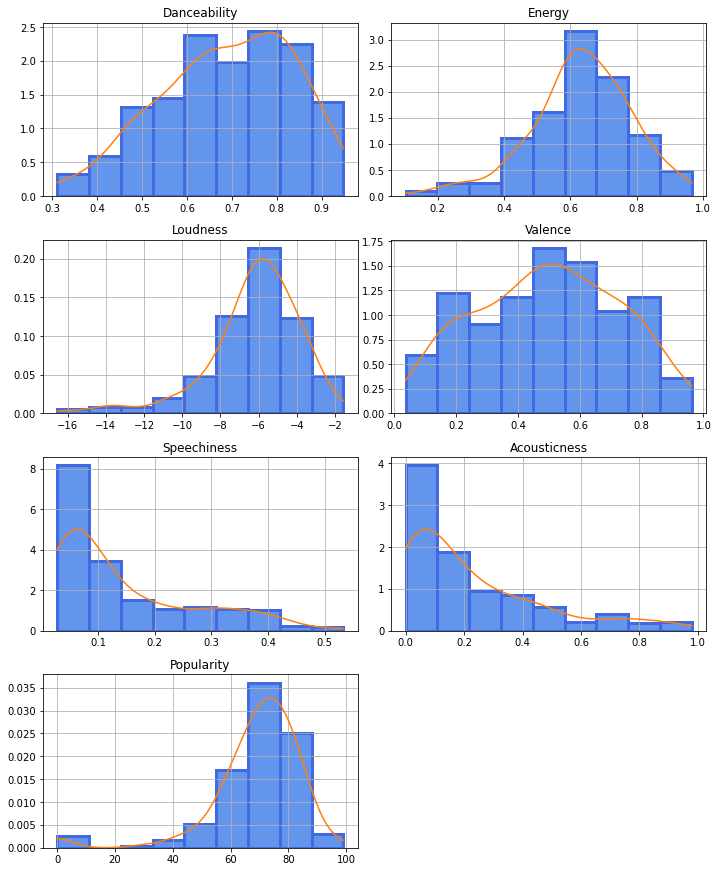

In [60]:
plot_pdf_estimated(sd_conditional,cols=2)
plt.savefig(fname = "./2.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [61]:
sd_conditional.mean()

Danceability     0.689561
Energy           0.631047
Loudness        -6.195336
Valence          0.496738
Speechiness      0.144232
Acousticness     0.225673
Popularity      69.032710
dtype: float64

In [62]:
sd_conditional.var()

Danceability      0.021668
Energy            0.023091
Loudness          5.772957
Valence           0.052590
Speechiness       0.014742
Acousticness      0.056513
Popularity      263.684371
dtype: float64

## Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.


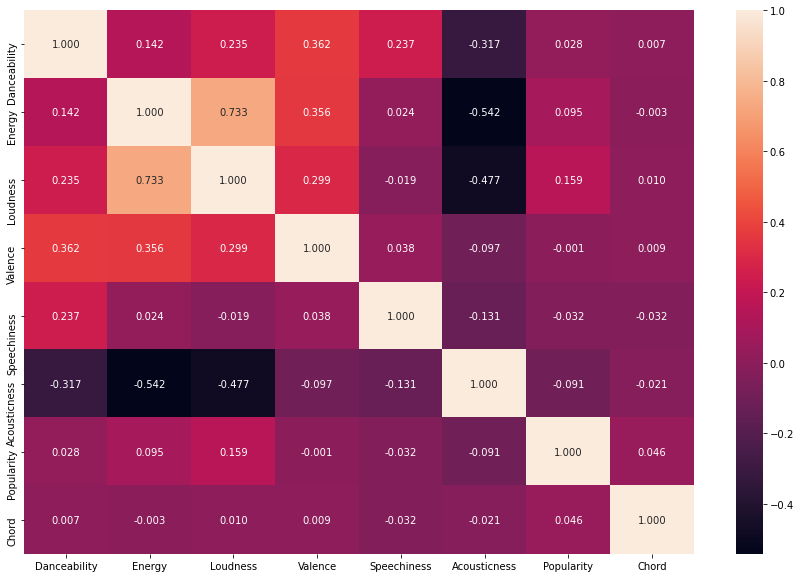

In [63]:
plt.figure(figsize=(15,10))
corr = subdata.corr()
sns.heatmap(corr, annot=True, fmt= '.3f')
plt.savefig(fname = "./3.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)


In [64]:
def conf_int_sign_corr(x,y):
    r, p = scipy.stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    return r,lo_z,hi_z,p

def calc_conf_int_sign_corr(x):
    N_cols = len(x.columns)
    r,lo_z,hi_z,p = np.zeros((N_cols,N_cols)),np.zeros((N_cols,N_cols)),np.zeros((N_cols,N_cols)),np.zeros((N_cols,N_cols))
    for i,col0 in enumerate(x.columns):
        for j,col1 in enumerate(x.columns):
            if i != j:
                r[i,j],lo_z[i,j],hi_z[i,j],p[i,j] = conf_int_sign_corr(x[col0],x[col1])
            else:
                r[i,j],lo_z[i,j],hi_z[i,j],p[i,j] = 1.0, 0.0, 0.0, 1.0
        
    numbers = 4
    print('Correlation coefficient')
    display(pd.DataFrame(np.round(r,numbers).astype(str),index=x.columns, columns=x.columns))

    print('Confidence interval for the correlation coefficient')
    lo = np.round(lo_z,numbers).astype(str)
    hi = np.round(hi_z,numbers).astype(str)
    interval = np.core.defchararray.add(lo, '; ')
    interval = np.core.defchararray.add(interval, hi)
    display(pd.DataFrame(interval,index=x.columns, columns=x.columns))

    print('Significance level')
    display(pd.DataFrame(np.round(p,numbers).astype(str),index=x.columns, columns=x.columns))

calc_conf_int_sign_corr(subdata)



Correlation coefficient


,Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Popularity,Chord
Danceability,1.0,0.1421,0.2349,0.3616,0.2374,-0.3168,0.0284,0.0073
Energy,0.1421,1.0,0.7326,0.3563,0.024,-0.5424,0.0947,-0.0034
Loudness,0.2349,0.7326,1.0,0.2988,-0.0188,-0.4774,0.1588,0.0095
Valence,0.3616,0.3563,0.2988,1.0,0.038,-0.097,-0.001,0.009
Speechiness,0.2374,0.024,-0.0188,0.038,1.0,-0.1314,-0.0321,-0.0316
Acousticness,-0.3168,-0.5424,-0.4774,-0.097,-0.1314,1.0,-0.0912,-0.0213
Popularity,0.0284,0.0947,0.1588,-0.001,-0.0321,-0.0912,1.0,0.0458
Chord,0.0073,-0.0034,0.0095,0.009,-0.0316,-0.0213,0.0458,1.0


Confidence interval for the correlation coefficient


,Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Popularity,Chord
Danceability,0.0; 0.0,0.0932; 0.193,0.1895; 0.2893,0.3288; 0.4287,0.1921; 0.2919,-0.378; -0.2782,-0.0215; 0.0784,-0.0426; 0.0572
Energy,0.0932; 0.193,0.0; 0.0,0.8844; 0.9843,0.3228; 0.4226,-0.0259; 0.0739,-0.6575; -0.5576,0.0451; 0.1449,-0.0534; 0.0465
Loudness,0.1895; 0.2893,0.8844; 0.9843,0.0; 0.0,0.2582; 0.3581,-0.0687; 0.0311,-0.5696; -0.4697,0.1102; 0.21,-0.0404; 0.0594
Valence,0.3288; 0.4287,0.3228; 0.4226,0.2582; 0.3581,0.0; 0.0,-0.0119; 0.088,-0.1472; -0.0474,-0.0509; 0.049,-0.041; 0.0589
Speechiness,0.1921; 0.2919,-0.0259; 0.0739,-0.0687; 0.0311,-0.0119; 0.088,0.0; 0.0,-0.1821; -0.0823,-0.082; 0.0178,-0.0816; 0.0183
Acousticness,-0.378; -0.2782,-0.6575; -0.5576,-0.5696; -0.4697,-0.1472; -0.0474,-0.1821; -0.0823,0.0; 0.0,-0.1414; -0.0416,-0.0712; 0.0286
Popularity,-0.0215; 0.0784,0.0451; 0.1449,0.1102; 0.21,-0.0509; 0.049,-0.082; 0.0178,-0.1414; -0.0416,0.0; 0.0,-0.0041; 0.0957
Chord,-0.0426; 0.0572,-0.0534; 0.0465,-0.0404; 0.0594,-0.041; 0.0589,-0.0816; 0.0183,-0.0712; 0.0286,-0.0041; 0.0957,0.0; 0.0


Significance level


,Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Popularity,Chord
Danceability,1.0,0.0,0.0,0.0,0.0,0.0,0.264,0.7745
Energy,0.0,1.0,0.0,0.0,0.346,0.0,0.0002,0.8924
Loudness,0.0,0.0,1.0,0.0,0.4597,0.0,0.0,0.7087
Valence,0.0,0.0,0.0,1.0,0.1351,0.0001,0.9701,0.7251
Speechiness,0.0,0.346,0.4597,0.1351,1.0,0.0,0.2074,0.214
Acousticness,0.0,0.0,0.0,0.0001,0.0,1.0,0.0003,0.4027
Popularity,0.264,0.0002,0.0,0.9701,0.2074,0.0003,1.0,0.072
Chord,0.7745,0.8924,0.7087,0.7251,0.214,0.4027,0.072,1.0


## Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).


#### Task: ***Predict*** popularity based on Danceability,Energy,Loudness,Valence,Speechiness,Acousticness,Chord
#### Multivariate correlation in the previous step

## Step 6. Build regression model and make an analysis of multicollinearity and regularization (if needed).


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
import pylab 


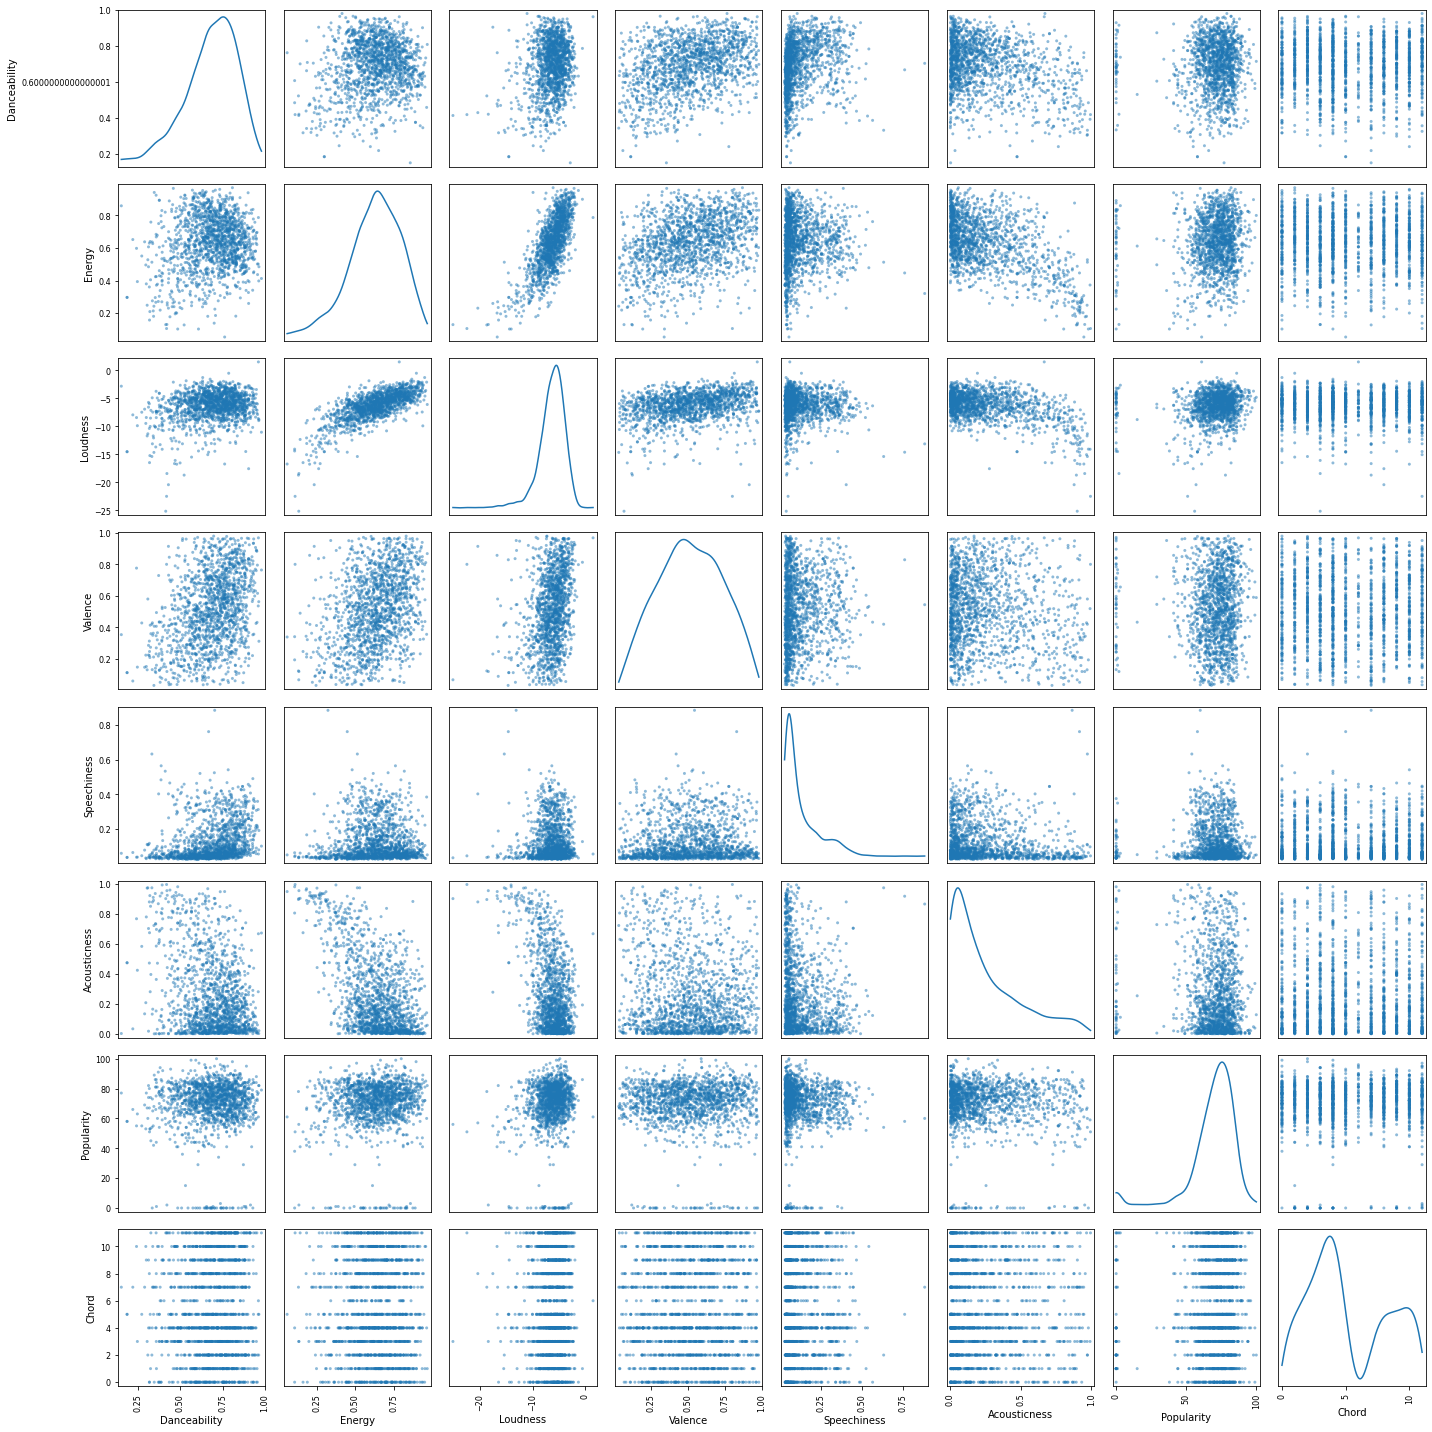

In [66]:
pd.plotting.scatter_matrix(subdata, diagonal="kde",figsize=(20,20))
plt.tight_layout()
plt.savefig(fname = "./4.png", dpi=300, facecolor='w', edgecolor='w', color='cornflowerblue',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [67]:
y = subdata['Popularity']
X = subdata.drop(columns=['Popularity','Danceability','Energy','Loudness'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2021)

reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)


In [68]:
#Построение и обучение полиномиальной регрессии 2-й степени
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new = poly.fit_transform(X)
y_pred_poly_all = reg.predict(X_new)

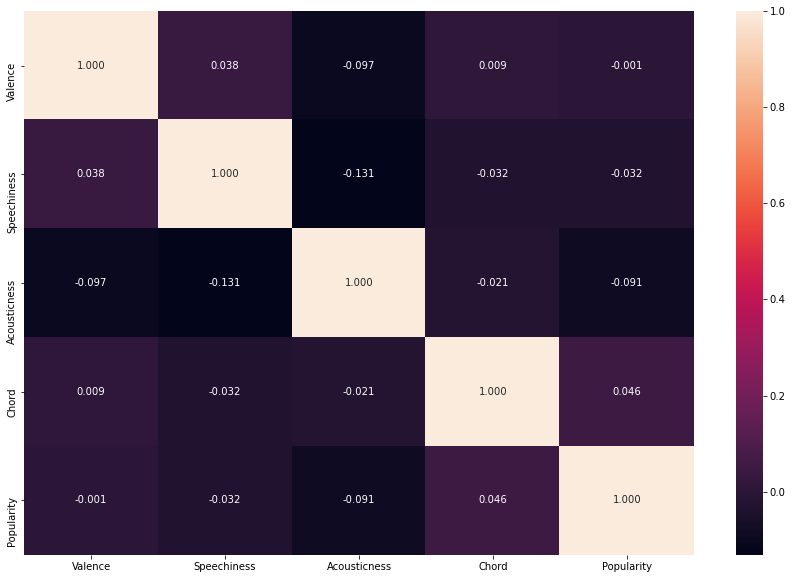

In [69]:
plt.figure(figsize=(15,10))
corr = X.join(y).corr()
sns.heatmap(corr, annot=True, fmt= '.3f')
plt.savefig(fname = "./5.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

## Step 7. Analyze the quality of regression model (distribution of residuals, determination coefficient).


In [70]:
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

Mean absolute error =  9.495792270226133
Mean squared error =  183.28653456905604


In [71]:
mae = mean_absolute_error(y_test, y_pred_poly)
mse = mean_squared_error(y_test, y_pred_poly)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

Mean absolute error =  9.509476113626052
Mean squared error =  185.3343611062335


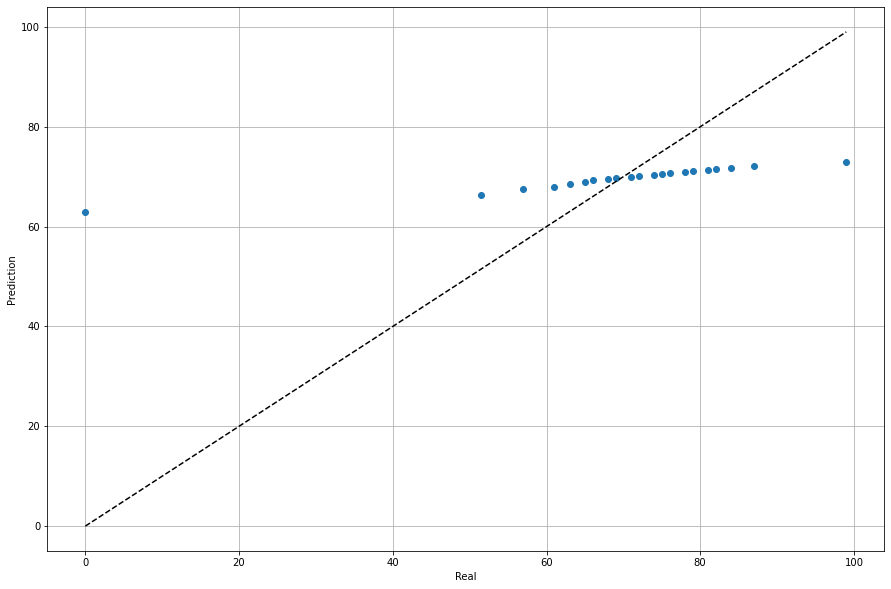

In [72]:
# Plotting a quantile biplot based on real and predicted values
plt.figure(figsize=(15,10))
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y_test, percs)
qn_second = np.percentile(y_pred, percs)
# plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')
plt.grid(True)
plt.savefig(fname = "./6.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

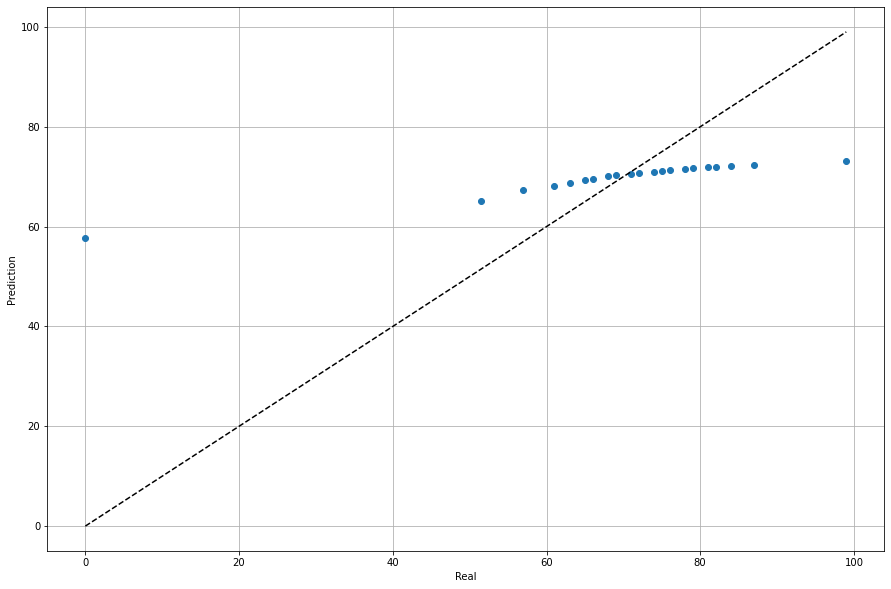

In [73]:
# Plotting a quantile biplot based on real and predicted values
plt.figure(figsize=(15,10))
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y_test, percs)
qn_second = np.percentile(y_pred_poly, percs)
# plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')
plt.grid(True)
plt.savefig(fname = "./7.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

KstestResult(statistic=0.11029790115647692, pvalue=7.371321886574091e-06) 	<-----------  Passed
Significance level 0.05


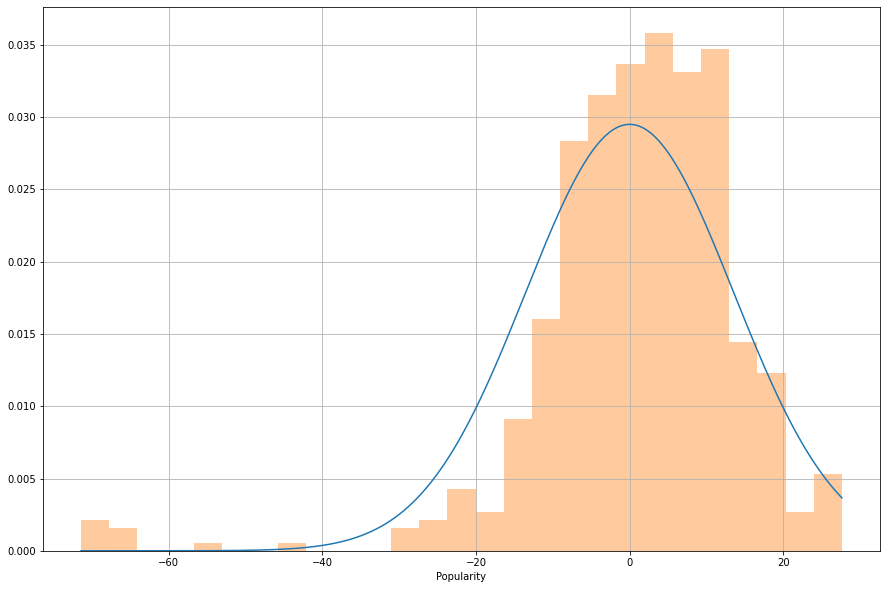

In [74]:
from scipy.stats import kstest, cramervonmises, norm
plt.figure(figsize=(15,10))
# The distribution of residuals
y_diff = y_test - y_pred

params = (0.0, y_diff.std())
x = np.linspace(y_diff.min(), y_diff.max(), len(y_pred))
vals = norm.pdf(x,*params)

plt.plot(x,vals)
ax = plt.gca()
sns.distplot(y_diff, kde=False, ax=ax, norm_hist=True)
plt.grid(True)

alpha = 0.05
ks_res = kstest(y_diff, 'norm', params, N=100)
print(ks_res,'\t<----------- ', 'Passed' if ks_res.pvalue < alpha else 'Not passed')
print(f'Significance level {alpha}')

plt.savefig(fname = "./8.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)


In [75]:
np.corrcoef(y_test,y_pred)

array([[1.        , 0.10033281],
       [0.10033281, 1.        ]])

In [76]:
for col in X_test.columns:
    print(f'Correlation coefficient between {col} and Popularity')
    display(pd.DataFrame(np.corrcoef(y_pred,X_test[col]),columns=['Popularity',col],index=['Popularity',col]))
    

Correlation coefficient between Valence and Popularity


,Popularity,Valence
Popularity,1.000000,-0.115987
Valence,-0.115987,1.000000


Correlation coefficient between Speechiness and Popularity


,Popularity,Speechiness
Popularity,1.000000,-0.087251
Speechiness,-0.087251,1.000000


Correlation coefficient between Acousticness and Popularity


,Popularity,Acousticness
Popularity,1.000000,-0.900637
Acousticness,-0.900637,1.000000


Correlation coefficient between Chord and Popularity


,Popularity,Chord
Popularity,1.000000,0.234511
Chord,0.234511,1.000000


In [77]:
for col in X_test.columns:
    print(f'Correlation coefficient between {col} and Popularity')
    display(pd.DataFrame(np.corrcoef(y_pred_poly,X_test[col]),columns=['Popularity',col],index=['Popularity',col]))
    

Correlation coefficient between Valence and Popularity


,Popularity,Valence
Popularity,1.000000,0.002048
Valence,0.002048,1.000000


Correlation coefficient between Speechiness and Popularity


,Popularity,Speechiness
Popularity,1.000000,-0.066045
Speechiness,-0.066045,1.000000


Correlation coefficient between Acousticness and Popularity


,Popularity,Acousticness
Popularity,1.000000,-0.604983
Acousticness,-0.604983,1.000000


Correlation coefficient between Chord and Popularity


,Popularity,Chord
Popularity,1.000000,0.150726
Chord,0.150726,1.000000


In [78]:
from sklearn.metrics import r2_score

print(f'Determination coefficient = {r2_score(y_test,y_pred)}')
print(f'Determination coefficient = {r2_score(y_test,y_pred_poly)}')

Determination coefficient = 0.005279849147618587
Determination coefficient = -0.005833975044486683


# Regularization

In [82]:
from sklearn.linear_model import  LassoLarsIC

clf = linear_model.Lasso(alpha=0.0001)
clf.fit(X_train, y_train)
print(clf.coef_)

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.coef_
alpha_aic_

[-1.99707847 -3.41591264 -6.69086725  0.11703083]


array([ 0.        ,  0.        , -4.76797526,  0.        ])

In [83]:
y_pred_lasso = clf.predict(X_test)
y_pred_lasso_aic = model_aic.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_lasso_aic = mean_squared_error(y_test, y_pred_lasso_aic)
mae_lasso_aic = mean_absolute_error(y_test, y_pred_lasso_aic)
print('Mean absolute error with lasso = ', mae_lasso)
print('Mean squared error with lasso = ', mse_lasso)
print('Mean absolute error with aic lasso = ', mae_lasso_aic)
print('Mean squared error with aic lasso = ', mse_lasso_aic)


Mean absolute error with lasso =  9.495814876303774
Mean squared error with lasso =  183.2870715057254
Mean absolute error with aic lasso =  9.536020298342807
Mean squared error with aic lasso =  184.16380514902835


In [84]:
for col in X_test.columns:
    print(f'Correlation coefficient between {col} and Popularity')
    display(pd.DataFrame(np.corrcoef(y_pred_lasso,X_test[col]),columns=['Popularity',col],index=['Popularity',col]))
    

Correlation coefficient between Valence and Popularity


,Popularity,Valence
Popularity,1.000000,-0.115734
Valence,-0.115734,1.000000


Correlation coefficient between Speechiness and Popularity


,Popularity,Speechiness
Popularity,1.000000,-0.086778
Speechiness,-0.086778,1.000000


Correlation coefficient between Acousticness and Popularity


,Popularity,Acousticness
Popularity,1.000000,-0.900793
Acousticness,-0.900793,1.000000


Correlation coefficient between Chord and Popularity


,Popularity,Chord
Popularity,1.000000,0.234585
Chord,0.234585,1.000000


In [85]:
for col in X_test.columns:
    print(f'Correlation coefficient between {col} and Popularity')
    display(pd.DataFrame(np.corrcoef(y_pred_lasso_aic,X_test[col]),columns=['Popularity',col],index=['Popularity',col]))
    

Correlation coefficient between Valence and Popularity


,Popularity,Valence
Popularity,1.000000,0.178921
Valence,0.178921,1.000000


Correlation coefficient between Speechiness and Popularity


,Popularity,Speechiness
Popularity,1.000000,0.174987
Speechiness,0.174987,1.000000


Correlation coefficient between Acousticness and Popularity


,Popularity,Acousticness
Popularity,1.0,-1.0
Acousticness,-1.0,1.0


Correlation coefficient between Chord and Popularity


,Popularity,Chord
Popularity,1.00000,-0.01083
Chord,-0.01083,1.00000


In [93]:
display(pd.DataFrame(np.corrcoef(y_pred_lasso_aic,y_diff),columns=['Predicted(lassoaic)','Residuals'],index=['Predicted','Residuals']))
display(pd.DataFrame(np.corrcoef(y_pred_lasso,y_diff),columns=['Predicted(lasso)','Residuals'],index=['Predicted','Residuals']))
display(pd.DataFrame(np.corrcoef(y_pred,y_diff),columns=['Predicted(linear)','Residuals'],index=['Predicted','Residuals']))
display(pd.DataFrame(np.corrcoef(y_pred_poly,y_diff),columns=['Predicted(poly2)','Residuals'],index=['Predicted','Residuals']))



,Predicted(lassoaic),Residuals
Predicted,1.000000,-0.034451
Residuals,-0.034451,1.000000


,Predicted(lasso),Residuals
Predicted,1.000000,-0.022391
Residuals,-0.022391,1.000000


,Predicted(linear),Residuals
Predicted,1.000000,-0.022374
Residuals,-0.022374,1.000000


,Predicted(poly2),Residuals
Predicted,1.000000,0.000951
Residuals,0.000951,1.000000


In [87]:
print(f'Determination coefficient = {r2_score(y_test,y_pred_lasso)}')
print(f'Determination coefficient = {r2_score(y_test,y_pred_lasso_aic)}')

Determination coefficient = 0.005276935121631854
Determination coefficient = 0.0005187862266562426
